# INF0616 - Aula 4: construindo uma rede simples com o Keras e PyTorch

Escrito por **Xavier Snelgrove** ([link to his GitHub](https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb)), com pequenas modificações de **Rafael Padilha**.

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Jesus Paucar -- j236865@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina:
[moodle.lab.ic.unicamp.br/680](https://moodle.ic.unicamp.br/moodle/course/view.php?id=680)

Instituto de Computação - Unicamp 2025


-----------

**This is a simple tutorial on working with neural networks in Keras. In this exercise, we will define, train and evaluate a simple feed-forward NN to classify handwritten digits.**

## Introdução ao Framework **PyTorch**

O **PyTorch** é um framework de *Deep Learning* desenvolvido pela **Meta (Facebook)**, amplamente utilizado em pesquisa e produção por sua **flexibilidade**, **eficiência** e **facilidade de uso**.  
Baseia-se em **tensores** (estruturas semelhantes aos arrays do NumPy) e utiliza o módulo **`autograd`** para realizar o cálculo automático de gradientes, o que simplifica o treinamento de redes neurais.

---

### Principais características

- **Execução dinâmica** (*define-by-run*): o grafo computacional é construído em tempo real, permitindo depuração e experimentação mais intuitivas.  
- **Suporte a GPU (CUDA):** acelera o treinamento utilizando o poder de processamento das placas gráficas.  
- **Ecossistema robusto:** inclui diversas bibliotecas complementares, como:  
  - `torchvision` → visão computacional  
  - `torchaudio` → processamento de áudio  
  - `torchtext` → processamento de linguagem natural  
- **Interface semelhante ao NumPy**, com operações vetorizadas de alto desempenho.

---

### Fluxo básico de trabalho com PyTorch

1. **Preparação dos dados:** usando `Dataset` e `DataLoader`, que organizam os dados e gerenciam os *batches*.  
2. **Definição do modelo:** criação de uma classe que herda de `nn.Module`.  
3. **Função de perda e otimizador:** definem como o modelo aprende.  
4. **Ciclo de treinamento:**  
   - Propagação direta (*forward pass*)  
   - Cálculo da perda (*loss*)  
   - Retropropagação (*backward pass*)  
   - Atualização dos pesos.  
5. **Avaliação e métricas:** medem o desempenho em validação e teste.

In [ ]:
import numpy as np
import pandas as pd
from random import shuffle, seed
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Subset
from torchvision import datasets, transforms

plt.rcParams['figure.figsize'] = (32, 32)
seed(42)

%matplotlib inline

In [ ]:
transform = transforms.ToTensor()

trainVal_dataset = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.8MB/s]


In [ ]:
indices = np.arange(len(trainVal_dataset))
np.random.seed(42)
np.random.shuffle(indices)

split = int(0.8 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]

train_data = Subset(trainVal_dataset, train_idx)
val_data   = Subset(trainVal_dataset, val_idx)

In [ ]:
X_train = np.array(train_data.dataset.data[train_data.indices], dtype = np.float32)
y_train = np.array(train_data.dataset.targets[train_data.indices], dtype = np.int64)

X_val = np.array(val_data.dataset.data[val_data.indices], dtype = np.float32)
y_val = np.array(val_data.dataset.targets[val_data.indices], dtype = np.int64)

X_test = np.array(test_data.data, dtype = np.float32)
y_test = np.array(test_data.targets, dtype = np.int64)

print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape), "\n"

print("X_val original shape", X_val.shape)
print("y_val original shape", y_val.shape), "\n"

print("X_test original shape", X_test.shape)
print("y_test original shape", y_test.shape)

X_train original shape (48000, 28, 28)
y_train original shape (48000,)
X_val original shape (12000, 28, 28)
y_val original shape (12000,)
X_test original shape (10000, 28, 28)
y_test original shape (10000,)


Let's look at some examples of the training data:

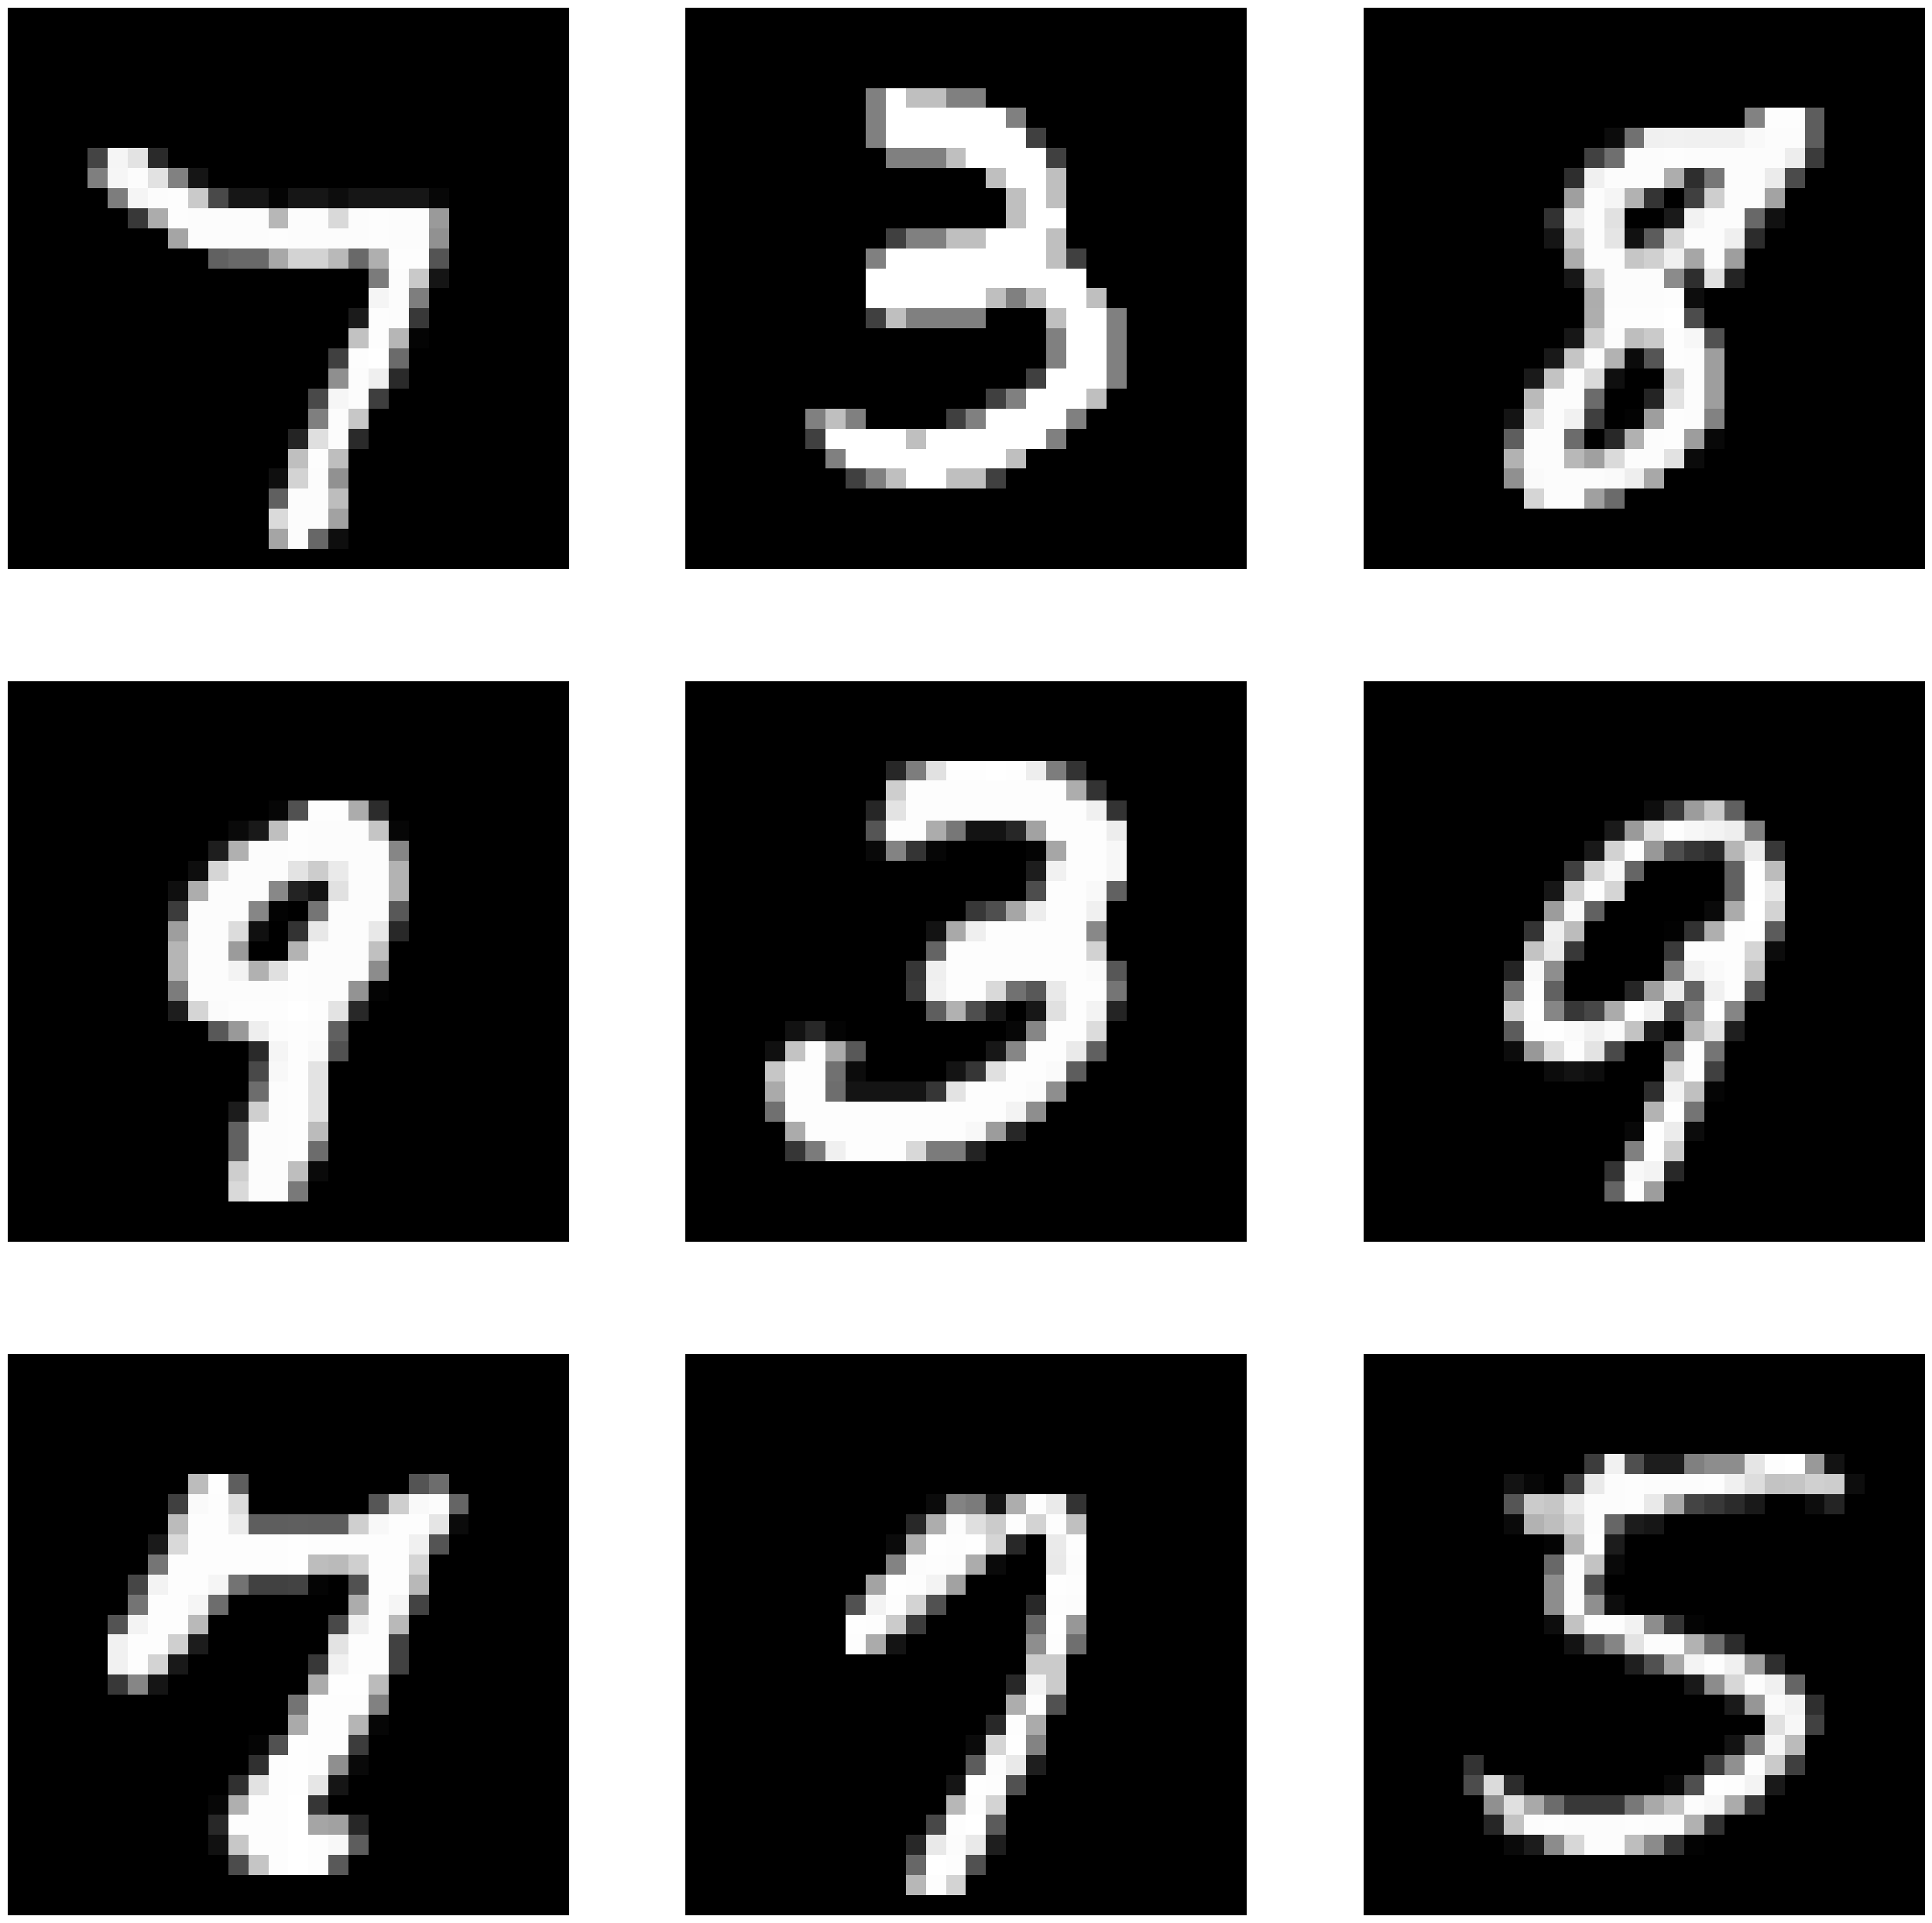

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.axis('off')

## O quão balanceado é o nosso treinamento?
Vamos encontrar quantas amostras estão contidas em cada classe e calular o peso das classes a partir disso. Isso é útil para dizer ao modelo que "preste mais atenção" em amostras sub-representadas, durante treinamento.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

unique, counts = np.unique(y_train, return_counts = True)
counts_dict_train = {int(k): int(v) for k, v in zip(unique, counts)}
print ("Train ---> ", counts_dict_train, "\n")

class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)

train_class_weights = {int(c): float(w) for c, w in zip(np.unique(y_train), class_weights)}
print (train_class_weights, "\n")

Train --->  {0: 4751, 1: 5355, 2: 4742, 3: 4966, 4: 4703, 5: 4355, 6: 4711, 7: 5007, 8: 4647, 9: 4763} 

{0: 1.0103136181856451, 1: 0.896358543417367, 2: 1.0122311261071277, 3: 0.9665726943213854, 4: 1.0206251328938976, 5: 1.1021814006888633, 6: 1.0188919549989386, 7: 0.9586578789694428, 8: 1.0329244673983216, 9: 1.0077682133109385} 



In [ ]:
unique, counts = np.unique(y_test, return_counts = True)
counts_dict_test = {int(k): int(v) for k, v in zip(unique, counts)}
print("Test ---> ", counts_dict_test, "\n")

test_sample_per_class = counts

Test --->  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009} 



## Preprocessamento
Nossa rede irá receber um único vetor para cada exemplo no conjunto, então precisamos "reformatar" o conjunto para que cada imagem de $28\times 28$ se transforme em um único vetor de 784 dimensões. Iremos também escalar os valores para que fiquem no intervalo $[0, 1]$ em vez de $[0, 255]$.

In [ ]:
size = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], size)
X_val = X_val.reshape(X_val.shape[0], size)
X_test = X_test.reshape(X_test.shape[0], size)

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (48000, 784)
Validation matrix shape (12000, 784)
Testing matrix shape (10000, 784)


## Criação do Dataset

Agora que os dados estão **preprocessados** e prontos, vamos encapsulá-los em uma classe `Dataset` personalizada para que o PyTorch possa usá-los facilmente. A classe `Dataset` precisa implementar dois métodos principais:

- **`__len__`**: para retornar o número de exemplos no conjunto de dados.
- **`__getitem__`**: para retornar uma amostra e sua etiqueta.

Neste caso, vamos criar um dataset para o conjunto de treinamento, testeo e validação, com as imagens reformatadas em vetores de 784 dimensões e valores escalados entre 0 e 1.

In [ ]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):

  def __init__(self, X, y):

    self.X = X
    self.y = y

  def __len__(self):

    return len(self.y)

  def __getitem__(self, idx):

    x = torch.tensor(self.X[idx], dtype = torch.float32)
    y = torch.tensor(self.y[idx], dtype = torch.long)

    return x, y

## Criação dos DataLoaders

Agora que temos o dataset encapsulado em uma classe `Dataset`, podemos criar **DataLoaders** para carregar os dados em *batches* durante o treinamento, validação e testagem. O **`DataLoader`** é responsável por:

- Dividir os dados em *batches*.
- Realizar o embaralhamento (`shuffle`) dos dados durante o treinamento.
- Garantir o carregamento eficiente dos dados.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128 #64

train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)
test_dataset = MNISTDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
print(f'Shape of x_batch: {x_batch.shape}')
print(f'Shape of y_batch: {y_batch.shape}')

Shape of x_batch: torch.Size([128, 784])
Shape of y_batch: torch.Size([128])


## Definição da Rede Neural

Agora que os dados estão prontos e os **DataLoaders** configurados, vamos construir a **rede neural** que será treinada. Neste caso, estamos usando uma rede simples com **camadas totalmente conectadas (fully connected)**.

A classe `NeuralMNIST` define a arquitetura da nossa rede neural com:

- 2 camadas ocultas (`fc1` e `fc2`), cada uma com **512 neurônios**.
- A camada de saída (`fc3`) tem **10 neurônios**, correspondendo às 10 classes do dataset MNIST.
- **Função de ativação ReLU** após cada camada oculta.
- **Sem Softmax** no final da rede, pois o PyTorch usará a função de perda `CrossEntropyLoss` que já lida com a normalização via softmax.


In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score

class NeuralMNIST(nn.Module):

  def __init__(self, input_dim):

    super(NeuralMNIST, self).__init__()

    self.fc1 = nn.Linear(in_features = input_dim, out_features = 512)
    self.fc2 = nn.Linear(in_features = 512, out_features = 512)
    self.fc3 = nn.Linear(in_features = 512, out_features = 10)
    self.activation1 = nn.ReLU()
    #self.activation2 = nn.Softmax()

  def forward(self, x):

    x = self.fc1(x)
    x = self.activation1(x)
    x = self.fc2(x)
    x = self.activation1(x)
    x = self.fc3(x)
    #x = self.activation2(x)

    return x

Podemos criar a rede neural com a API PyTorch usando o módulo **nn.Sequential** da seguinte maneira:

```
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 6)
)
```

## Processo de Treinamento

Neste passo, vamos treinar o modelo utilizando o conjunto de dados de treinamento e validar o desempenho no conjunto de validação a cada época. Durante o treinamento, calculamos as métricas de **perda** (loss) e **precisão balanceada** (balanced accuracy) tanto para os dados de treinamento quanto para os dados de validação.

O código a seguir realiza as seguintes tarefas:

1. **Treinamento do modelo:** Passa as imagens de entrada pelo modelo, calcula a perda, faz o **backpropagation** e atualiza os pesos.
2. **Cálculo da precisão balanceada:** Calcula a precisão considerando as desproporções entre as classes.
3. **Avaliação do modelo:** Após cada época, o modelo é avaliado no conjunto de validação, e o melhor modelo (com maior precisão balanceada) é salvo.

O código implementa tudo isso e faz o salvamento do **melhor modelo** em um arquivo, para que possamos usar o modelo treinado posteriormente.


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs = 10, device = 'cpu', save_path = 'best_model.pth'):

  model.to(device)

  history = {'train_loss': [], 'val_loss': [], 'train_bal_acc': [], 'val_bal_acc': []}

  best_val_bal_acc = 0.0

  for epoch in range(epochs):

    model.train()

    train_loss, train_preds, train_labels = 0.0, [], []

    loop = tqdm(train_loader, desc = f'Epoch [{epoch + 1} / {epochs}]', leave = False)

    for image, label in loop:

      image, label = image.to(device), label.to(device)

      optimizer.zero_grad()
      outputs = model(image)
      loss = criterion(outputs, label)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * image.size(0)
      _, preds = torch.max(outputs, 1)
      train_preds.extend(preds.detach().cpu().numpy())
      train_labels.extend(label.detach().cpu().numpy())

      loop.set_postfix(loss = loss.item())

    train_loss /= len(train_loader.dataset)
    train_bal_acc = balanced_accuracy_score(train_labels, train_preds)

    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    with torch.no_grad():

      for image, label in val_loader:

        image, label = image.to(device), label.to(device)

        outputs = model(image)
        loss = criterion(outputs, label)

        val_loss += loss.item() * image.size(0)
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.detach().cpu().numpy())
        val_labels.extend(label.detach().cpu().numpy())

      val_loss /= len(val_loader.dataset)
      val_bal_acc = balanced_accuracy_score(val_labels, val_preds)

      history['train_loss'].append(train_loss)
      history['val_loss'].append(val_loss)
      history['train_bal_acc'].append(train_bal_acc)
      history['val_bal_acc'].append(val_bal_acc)

      print(f'Epoch [{epoch + 1} / {epochs}] '
            f'Train Loss: {train_loss:.4f}, Train Bal. Acc: {train_bal_acc:.4f} '
            f'| Val Loss: {val_loss:.4f}, Val Bal. Acc: {val_bal_acc:.4f}')

      if val_bal_acc > best_val_bal_acc:

        best_val_bal_acc = val_bal_acc
        torch.save(model.state_dict(), save_path)
        print('-' * 100)
        print(f'Melhor modelo atualizado (Bal. Acc: {best_val_bal_acc:.4f}) salvo em {save_path}')
        print('-' * 100)

  return history

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_loader, device = 'cpu'):

  model.eval()

  test_preds, test_labels = [], []

  with torch.no_grad():

    for image, label in test_loader:

      image, label = image.to(device), label.to(device)
      outputs = model(image)
      _, preds = torch.max(outputs, 1)
      test_preds.extend(preds.detach().cpu().numpy())
      test_labels.extend(label.detach().cpu().numpy())

  balanced_test_acc = balanced_accuracy_score(test_labels, test_preds)
  print(f'Test Balanced Accuracy: {balanced_test_acc:.4f}')
  print('-' * 60)
  print(classification_report(test_labels, test_preds))

  return test_labels, test_preds, balanced_test_acc

In [ ]:
def plot_history(history):

  plt.figure(figsize = (16, 8))

  plt.subplot(1, 2, 1)
  plt.plot(history['train_loss'], label = 'Train Loss')
  plt.plot(history['val_loss'], label = 'Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss x Epoch')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history['train_bal_acc'], label = 'Train Balanced Accuracy')
  plt.plot(history['val_bal_acc'], label = 'Val Balanced Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Balanced Accuracy')
  plt.title('Bal. Accuracy x Epoch')
  plt.legend()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 30
model = NeuralMNIST(input_dim = 784).to(device)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights)).to(device)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

In [ ]:
history = train_model(model = model,
                      train_loader = train_loader,
                      val_loader = val_loader,
                      criterion = criterion,
                      optimizer = optimizer,
                      epochs = epochs,
                      device = device)

Epoch [1 / 30] Train Loss: 2.1605, Train Bal. Acc: 0.4877 | Val Loss: 1.8906, Val Bal. Acc: 0.6976
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.6976) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [2 / 30] Train Loss: 1.3324, Train Bal. Acc: 0.7714 | Val Loss: 0.8681, Val Bal. Acc: 0.8157
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.8157) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [3 / 30] Train Loss: 0.6856, Train Bal. Acc: 0.8364 | Val Loss: 0.5677, Val Bal. Acc: 0.8549
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.8549) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [4 / 30] Train Loss: 0.5076, Train Bal. Acc: 0.8670 | Val Loss: 0.4603, Val Bal. Acc: 0.8761
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.8761) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [5 / 30] Train Loss: 0.4321, Train Bal. Acc: 0.8831 | Val Loss: 0.4075, Val Bal. Acc: 0.8878
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.8878) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [6 / 30] Train Loss: 0.3901, Train Bal. Acc: 0.8919 | Val Loss: 0.3758, Val Bal. Acc: 0.8939
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.8939) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [7 / 30] Train Loss: 0.3628, Train Bal. Acc: 0.8980 | Val Loss: 0.3537, Val Bal. Acc: 0.8985
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.8985) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [8 / 30] Train Loss: 0.3429, Train Bal. Acc: 0.9040 | Val Loss: 0.3374, Val Bal. Acc: 0.9037
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9037) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [9 / 30] Train Loss: 0.3267, Train Bal. Acc: 0.9071 | Val Loss: 0.3236, Val Bal. Acc: 0.9056
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9056) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [10 / 30] Train Loss: 0.3136, Train Bal. Acc: 0.9115 | Val Loss: 0.3118, Val Bal. Acc: 0.9094
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9094) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [11 / 30] Train Loss: 0.3024, Train Bal. Acc: 0.9147 | Val Loss: 0.3016, Val Bal. Acc: 0.9118
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9118) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [12 / 30] Train Loss: 0.2921, Train Bal. Acc: 0.9171 | Val Loss: 0.2926, Val Bal. Acc: 0.9152
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9152) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [13 / 30] Train Loss: 0.2829, Train Bal. Acc: 0.9197 | Val Loss: 0.2864, Val Bal. Acc: 0.9168
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9168) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [14 / 30] Train Loss: 0.2742, Train Bal. Acc: 0.9219 | Val Loss: 0.2772, Val Bal. Acc: 0.9181
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9181) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [15 / 30] Train Loss: 0.2662, Train Bal. Acc: 0.9244 | Val Loss: 0.2695, Val Bal. Acc: 0.9215
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9215) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [16 / 30] Train Loss: 0.2584, Train Bal. Acc: 0.9268 | Val Loss: 0.2635, Val Bal. Acc: 0.9222
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9222) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [17 / 30] Train Loss: 0.2513, Train Bal. Acc: 0.9287 | Val Loss: 0.2571, Val Bal. Acc: 0.9242
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9242) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [18 / 30] Train Loss: 0.2445, Train Bal. Acc: 0.9304 | Val Loss: 0.2495, Val Bal. Acc: 0.9272
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9272) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [19 / 30] Train Loss: 0.2377, Train Bal. Acc: 0.9330 | Val Loss: 0.2439, Val Bal. Acc: 0.9287
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9287) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [20 / 30] Train Loss: 0.2315, Train Bal. Acc: 0.9345 | Val Loss: 0.2378, Val Bal. Acc: 0.9298
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9298) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [21 / 30] Train Loss: 0.2253, Train Bal. Acc: 0.9361 | Val Loss: 0.2322, Val Bal. Acc: 0.9313
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9313) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [22 / 30] Train Loss: 0.2194, Train Bal. Acc: 0.9380 | Val Loss: 0.2275, Val Bal. Acc: 0.9321
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9321) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [23 / 30] Train Loss: 0.2138, Train Bal. Acc: 0.9398 | Val Loss: 0.2235, Val Bal. Acc: 0.9344
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9344) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [24 / 30] Train Loss: 0.2086, Train Bal. Acc: 0.9414 | Val Loss: 0.2190, Val Bal. Acc: 0.9356
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9356) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [25 / 30] Train Loss: 0.2035, Train Bal. Acc: 0.9424 | Val Loss: 0.2130, Val Bal. Acc: 0.9374
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9374) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [26 / 30] Train Loss: 0.1984, Train Bal. Acc: 0.9435 | Val Loss: 0.2081, Val Bal. Acc: 0.9392
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9392) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [27 / 30] Train Loss: 0.1936, Train Bal. Acc: 0.9451 | Val Loss: 0.2047, Val Bal. Acc: 0.9395
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9395) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [28 / 30] Train Loss: 0.1890, Train Bal. Acc: 0.9464 | Val Loss: 0.2011, Val Bal. Acc: 0.9409
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9409) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [29 / 30] Train Loss: 0.1846, Train Bal. Acc: 0.9476 | Val Loss: 0.1972, Val Bal. Acc: 0.9423
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9423) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


Epoch [30 / 30] Train Loss: 0.1803, Train Bal. Acc: 0.9489 | Val Loss: 0.1928, Val Bal. Acc: 0.9434
----------------------------------------------------------------------------------------------------
Melhor modelo atualizado (Bal. Acc: 0.9434) salvo em best_model.pth
----------------------------------------------------------------------------------------------------


In [ ]:
history_f = pd.DataFrame(history)
history_f.head()

,train_loss,val_loss,train_bal_acc,val_bal_acc
0,2.160473,1.890602,0.487731,0.697637
1,1.332365,0.868110,0.771356,0.815739
2,0.685558,0.567708,0.836359,0.854872
3,0.507551,0.460272,0.866969,0.876113
4,0.432090,0.407455,0.883132,0.887841


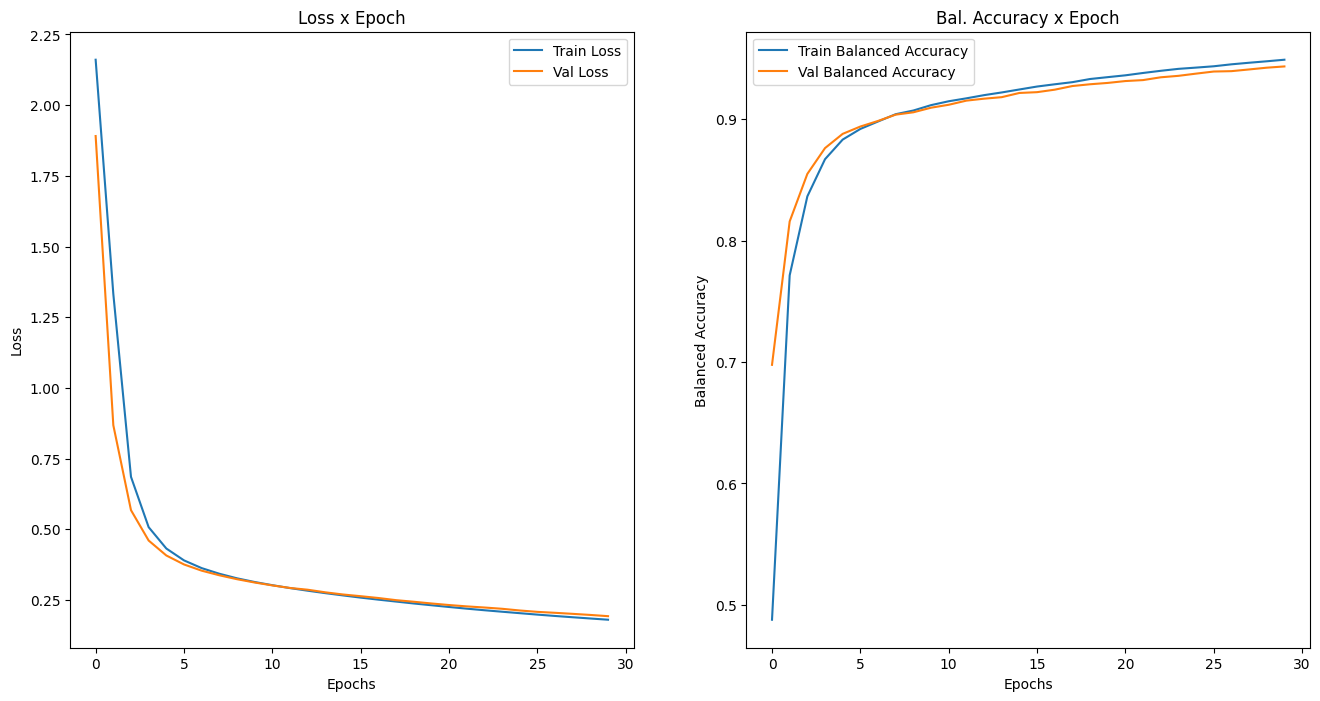

In [ ]:
plot_history(history = history)

In [ ]:
best_model = NeuralMNIST(input_dim = 784)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)
best_model.eval()

NeuralMNIST(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (activation1): ReLU()
)

In [ ]:
true_test, pred_test, acc_test = evaluate_model(model = best_model, test_loader = test_loader, device = device)

Test Balanced Accuracy: 0.9470
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.95      0.94      0.95      1032
           3       0.93      0.95      0.94      1010
           4       0.93      0.96      0.94       982
           5       0.95      0.92      0.93       892
           6       0.94      0.97      0.95       958
           7       0.96      0.94      0.95      1028
           8       0.94      0.92      0.93       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



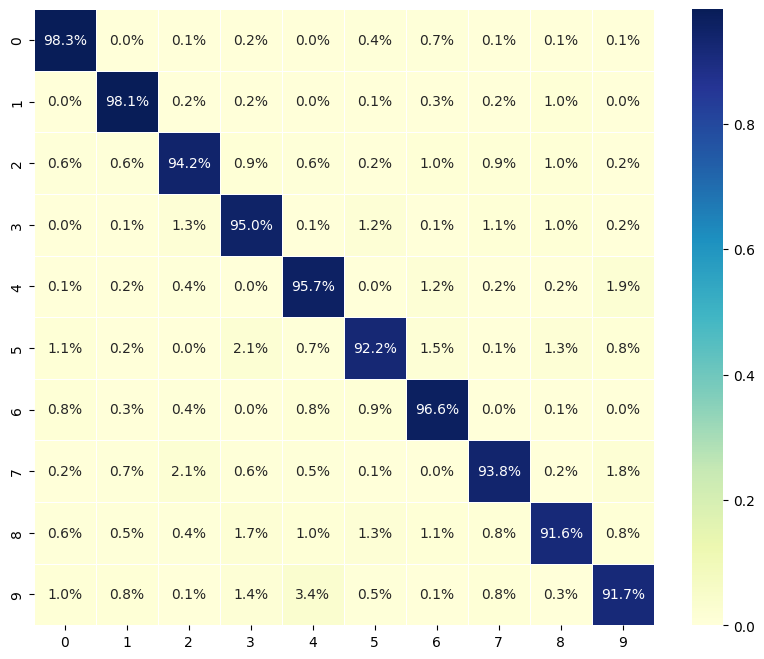

In [ ]:
c = confusion_matrix(true_test, pred_test, normalize = 'true')

plt.figure(figsize=(10, 8))
ax = sns.heatmap(c, linewidths=.5, cmap = 'YlGnBu', annot = True, fmt = '.1%');

In [ ]:
# Determina os índices das amostras que foram preditas corretamente/incorretamente
correct_indices, = np.where(np.array(pred_test) == np.array(true_test))
incorrect_indices, = np.where(np.array(pred_test) != np.array(true_test))

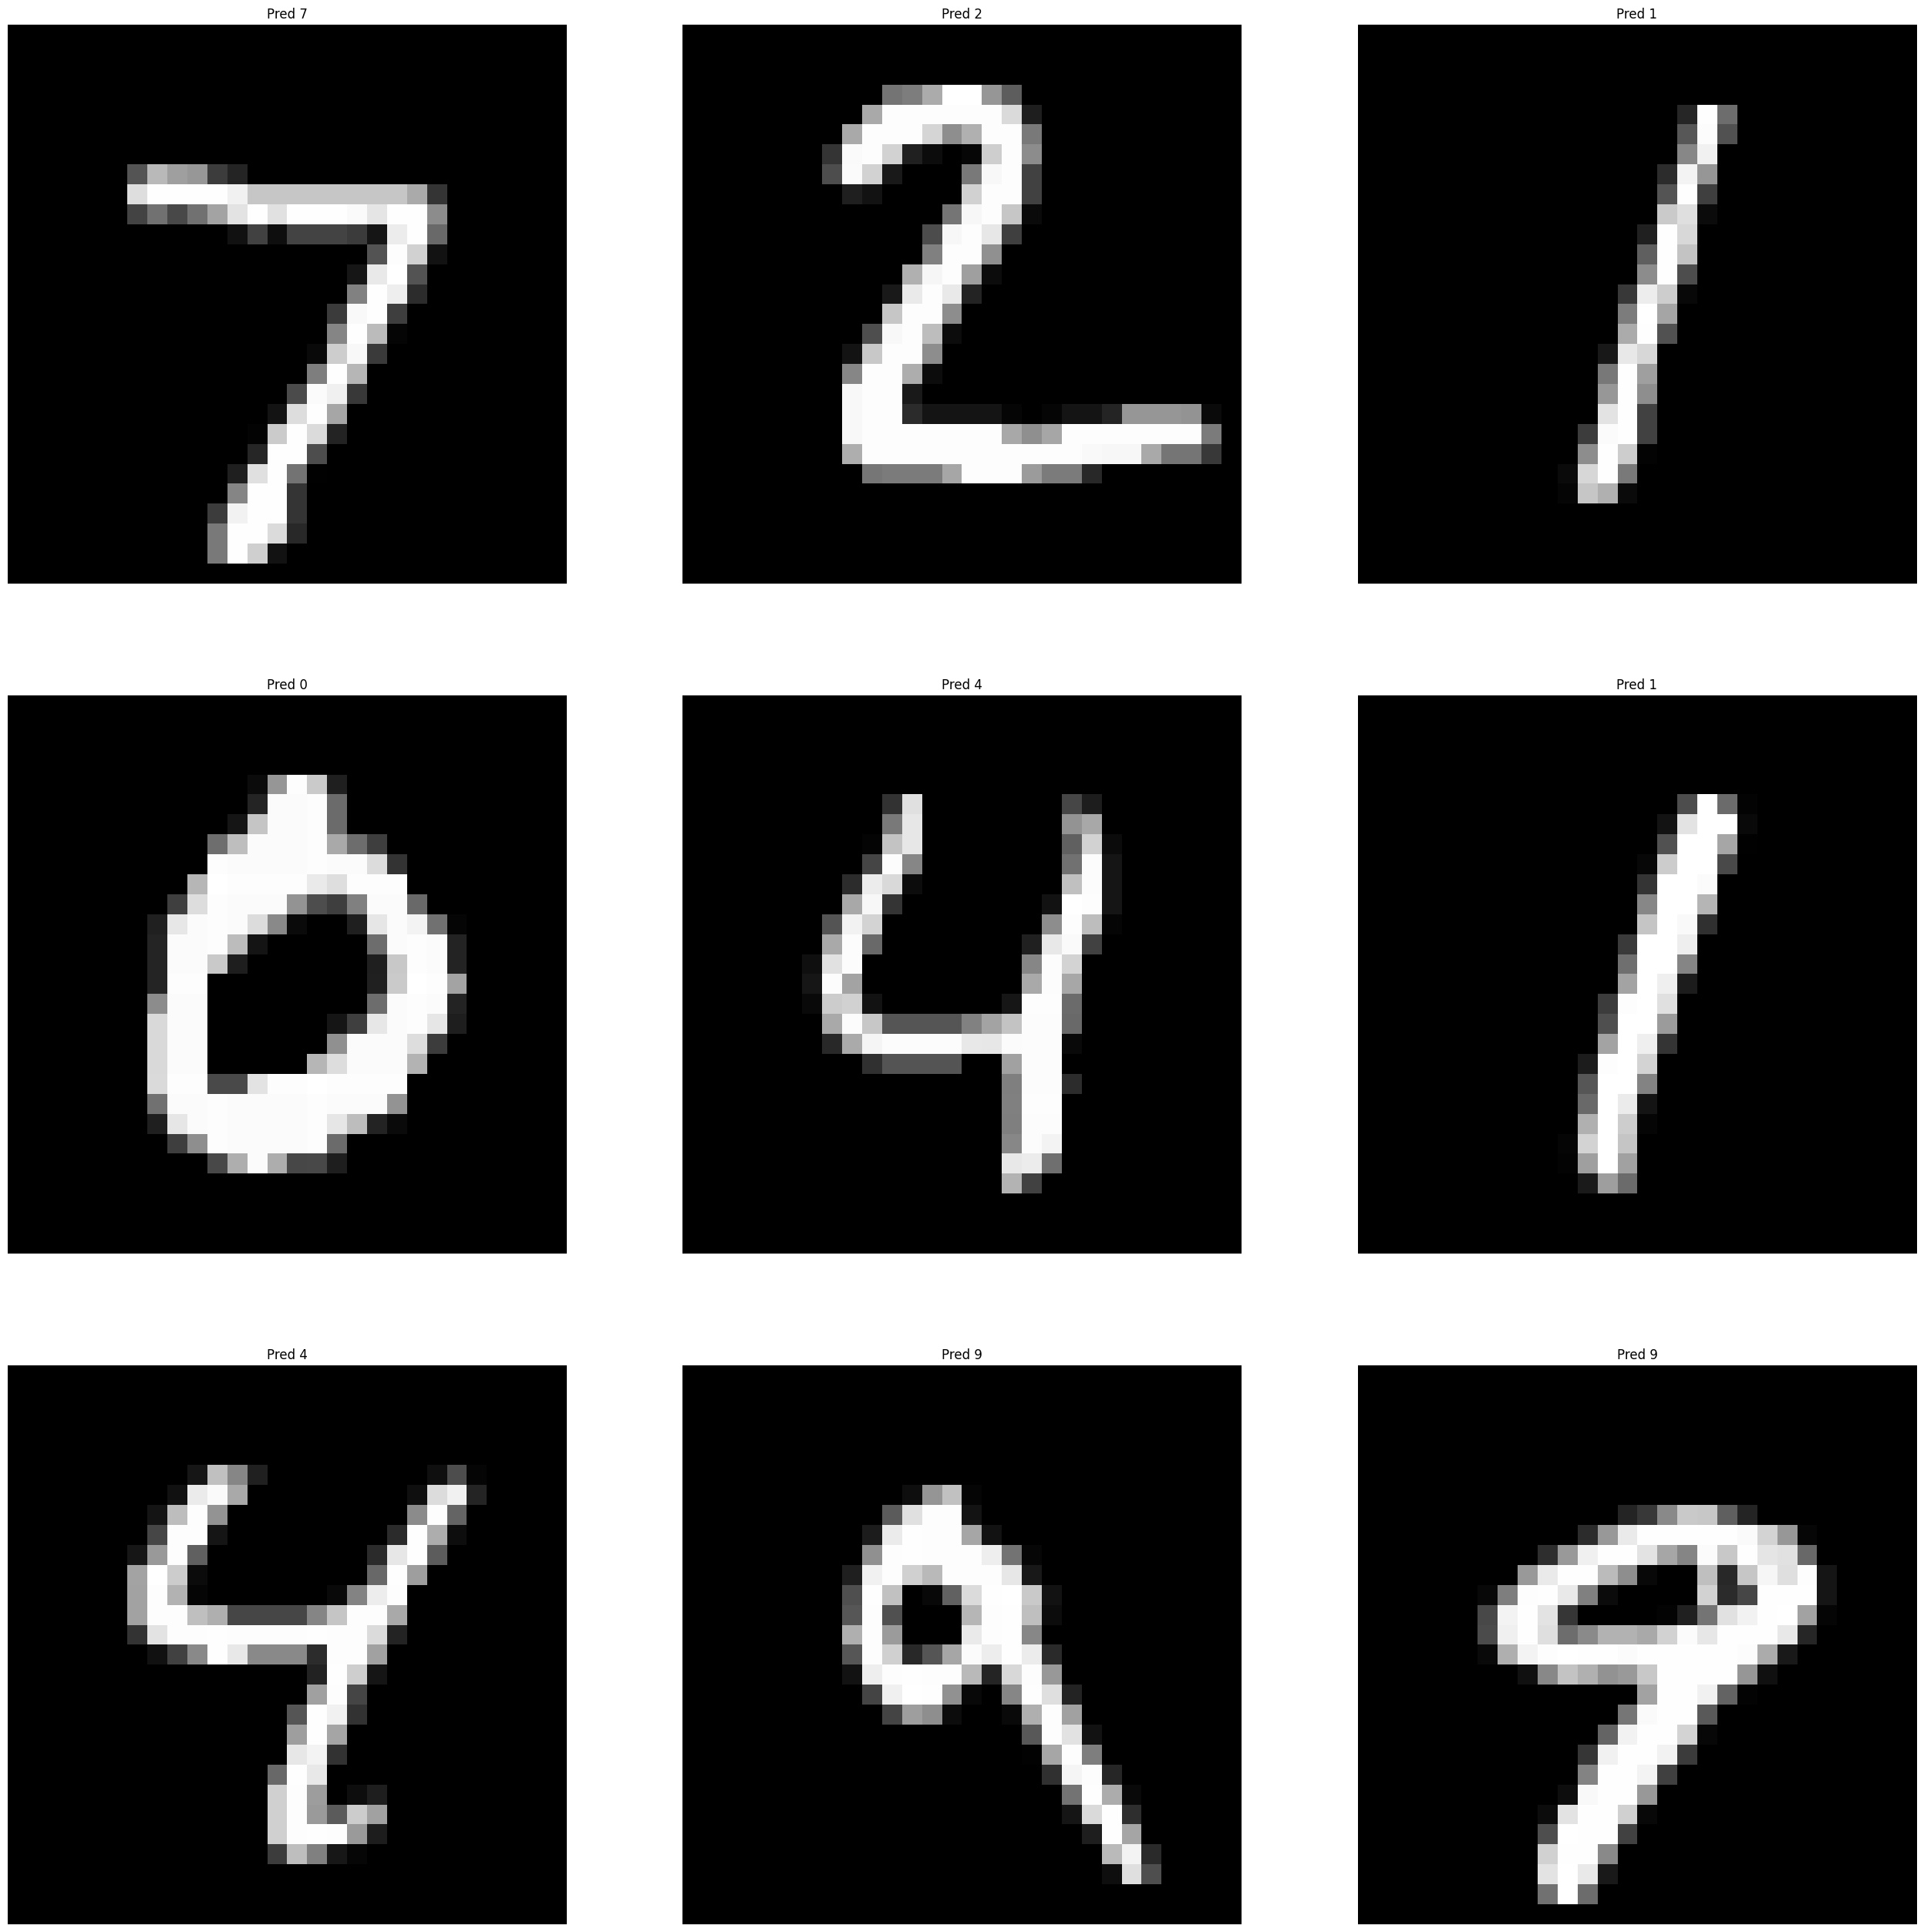

In [ ]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Pred {}".format(pred_test[correct]))
    plt.axis('off')

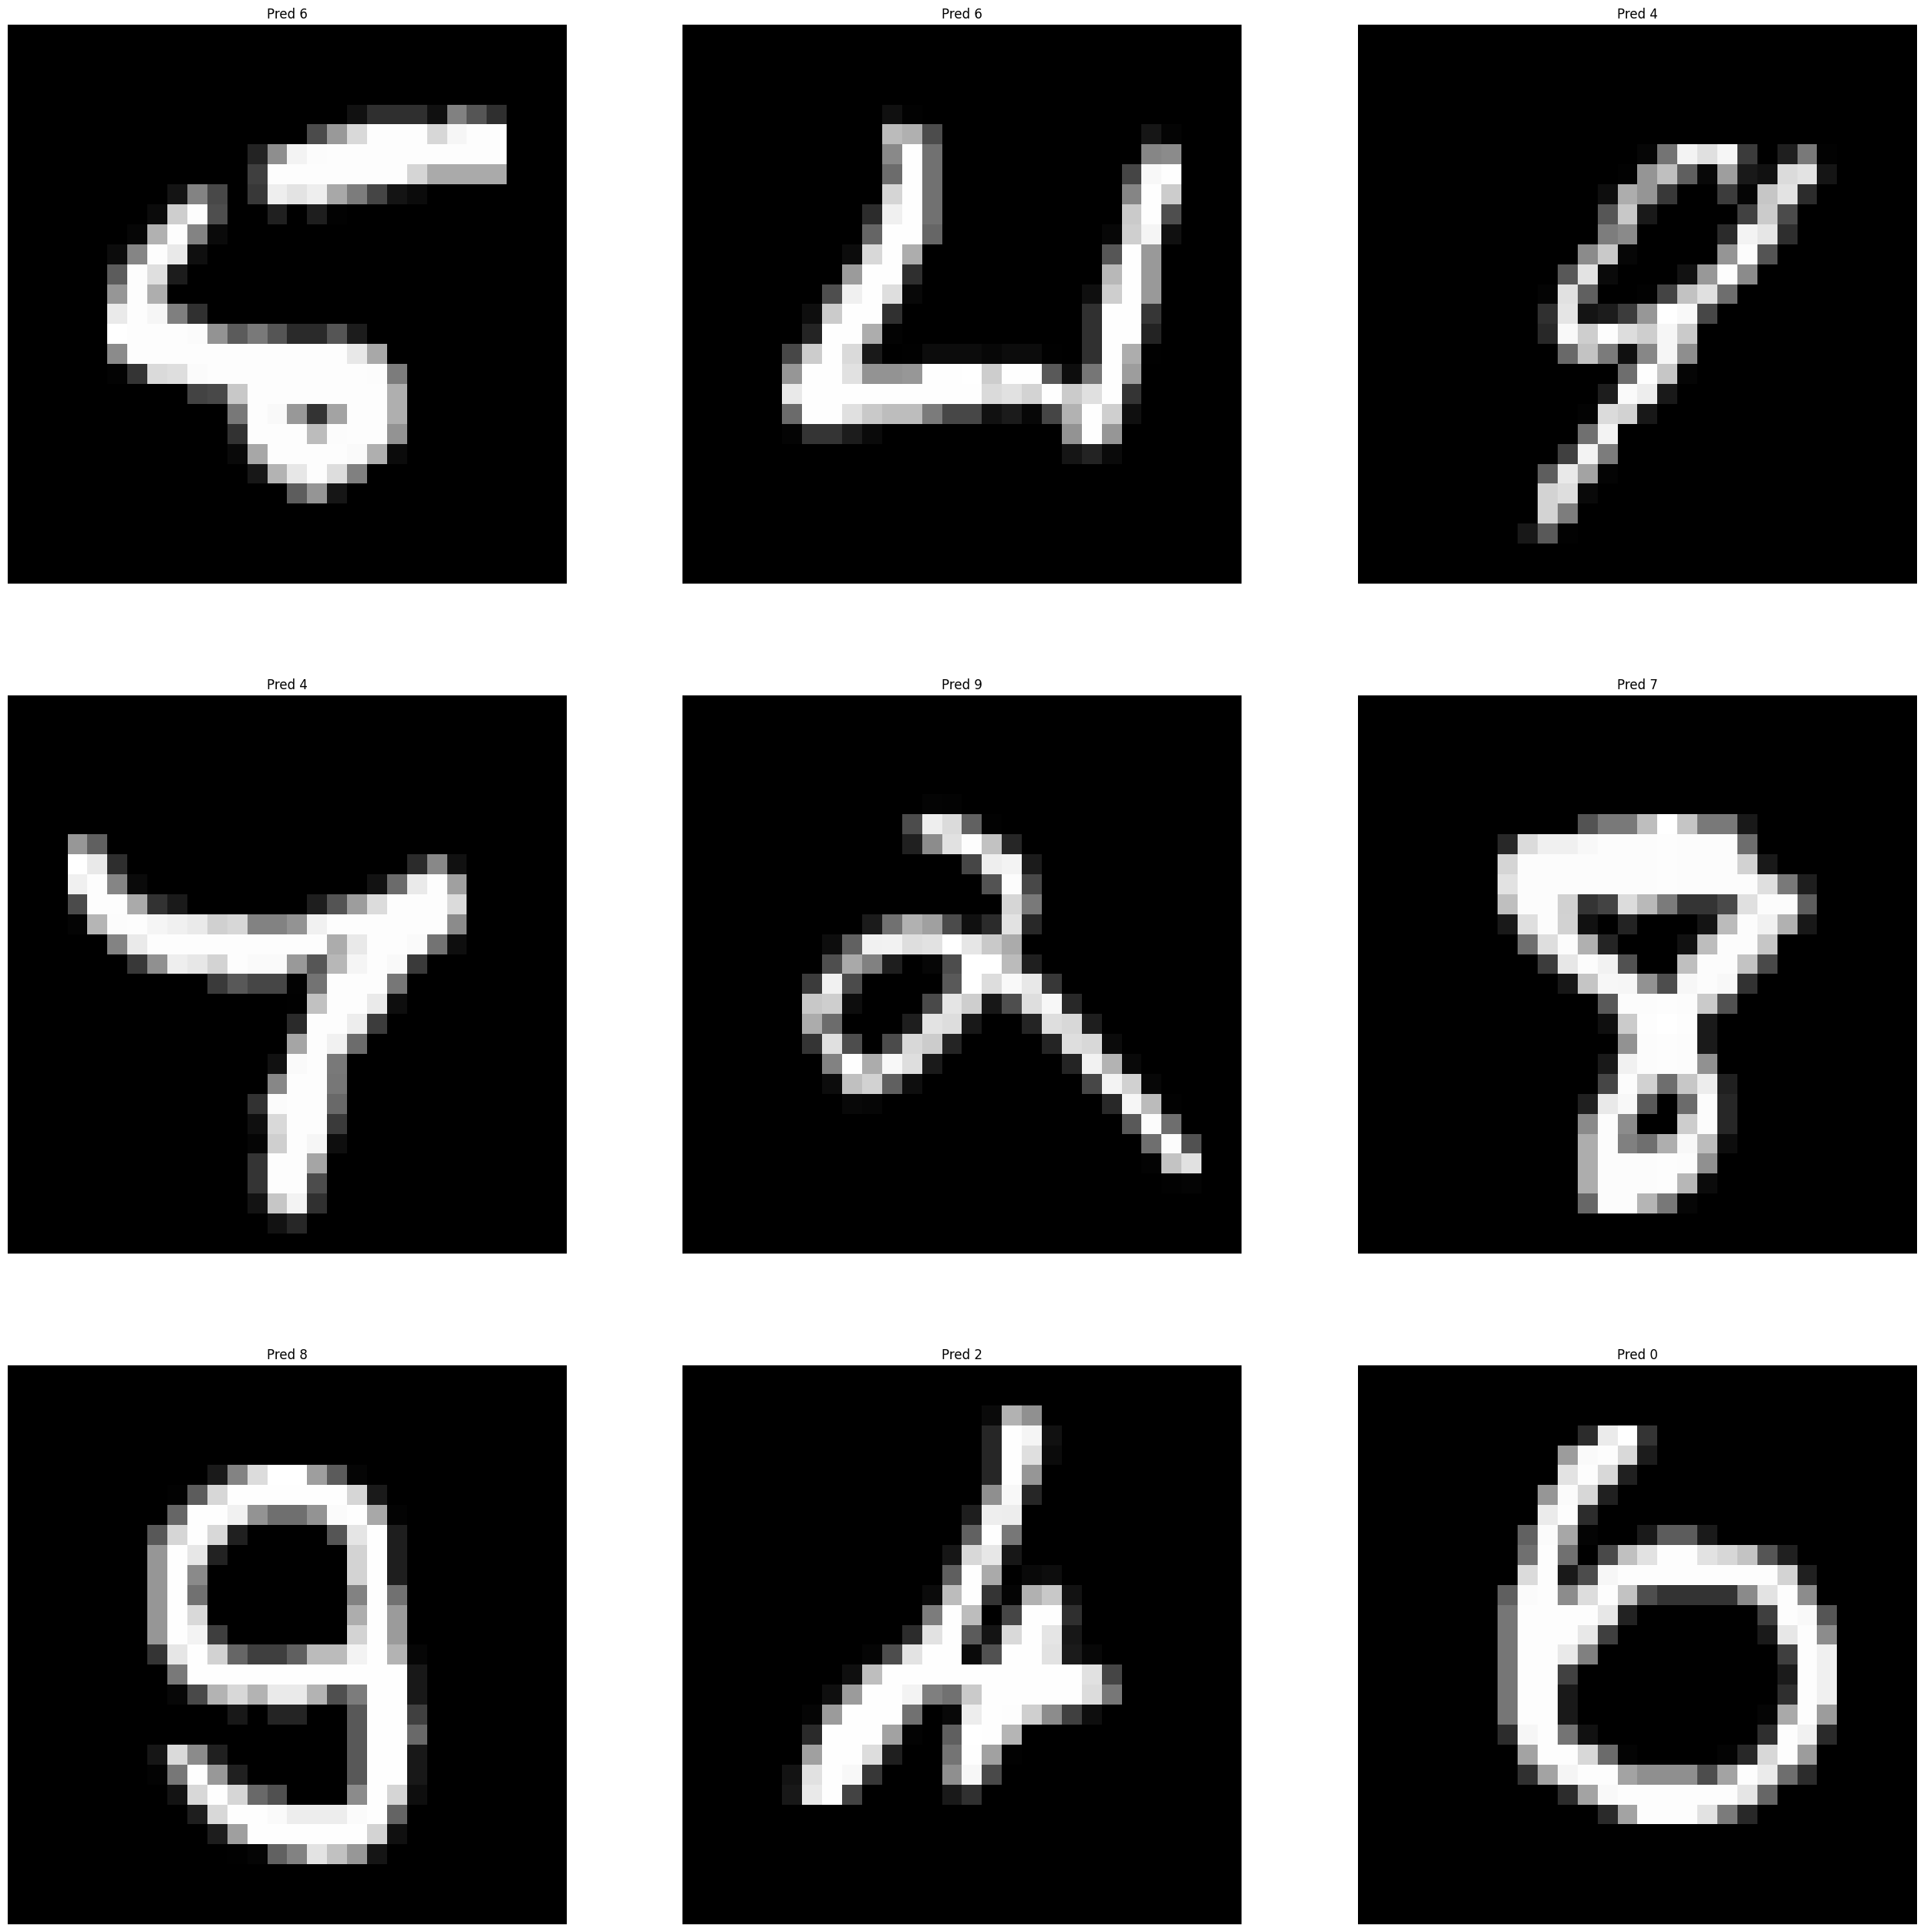

In [ ]:
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Pred {}".format(pred_test[incorrect]))
    plt.axis('off')

In [ ]:
import numpy as np
from random import shuffle, seed
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, Input
from keras.utils import to_categorical
from keras import optimizers

plt.rcParams['figure.figsize'] = (32,32) # Make the figures a bit bigger
seed(42)

%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import matplotlib.pyplot as plt

nb_classes = 10

# Os dados são carregados já embaralhados e separados em treino e teste.
(trainVal_data, trainVal_label), (X_test, y_test) = mnist.load_data()

# Separamos trainVal em treino e validação.
(X_train, X_val, y_train, y_val) = train_test_split(trainVal_data, trainVal_label,
                                                    test_size=0.2)
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape), "\n"

print("X_val original shape", X_val.shape)
print("y_val original shape", y_val.shape), "\n"

print("X_test original shape", X_test.shape)
print("y_test original shape", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train original shape (48000, 28, 28)
y_train original shape (48000,)
X_val original shape (12000, 28, 28)
y_val original shape (12000,)
X_test original shape (10000, 28, 28)
y_test original shape (10000,)


Let's look at some examples of the training data:

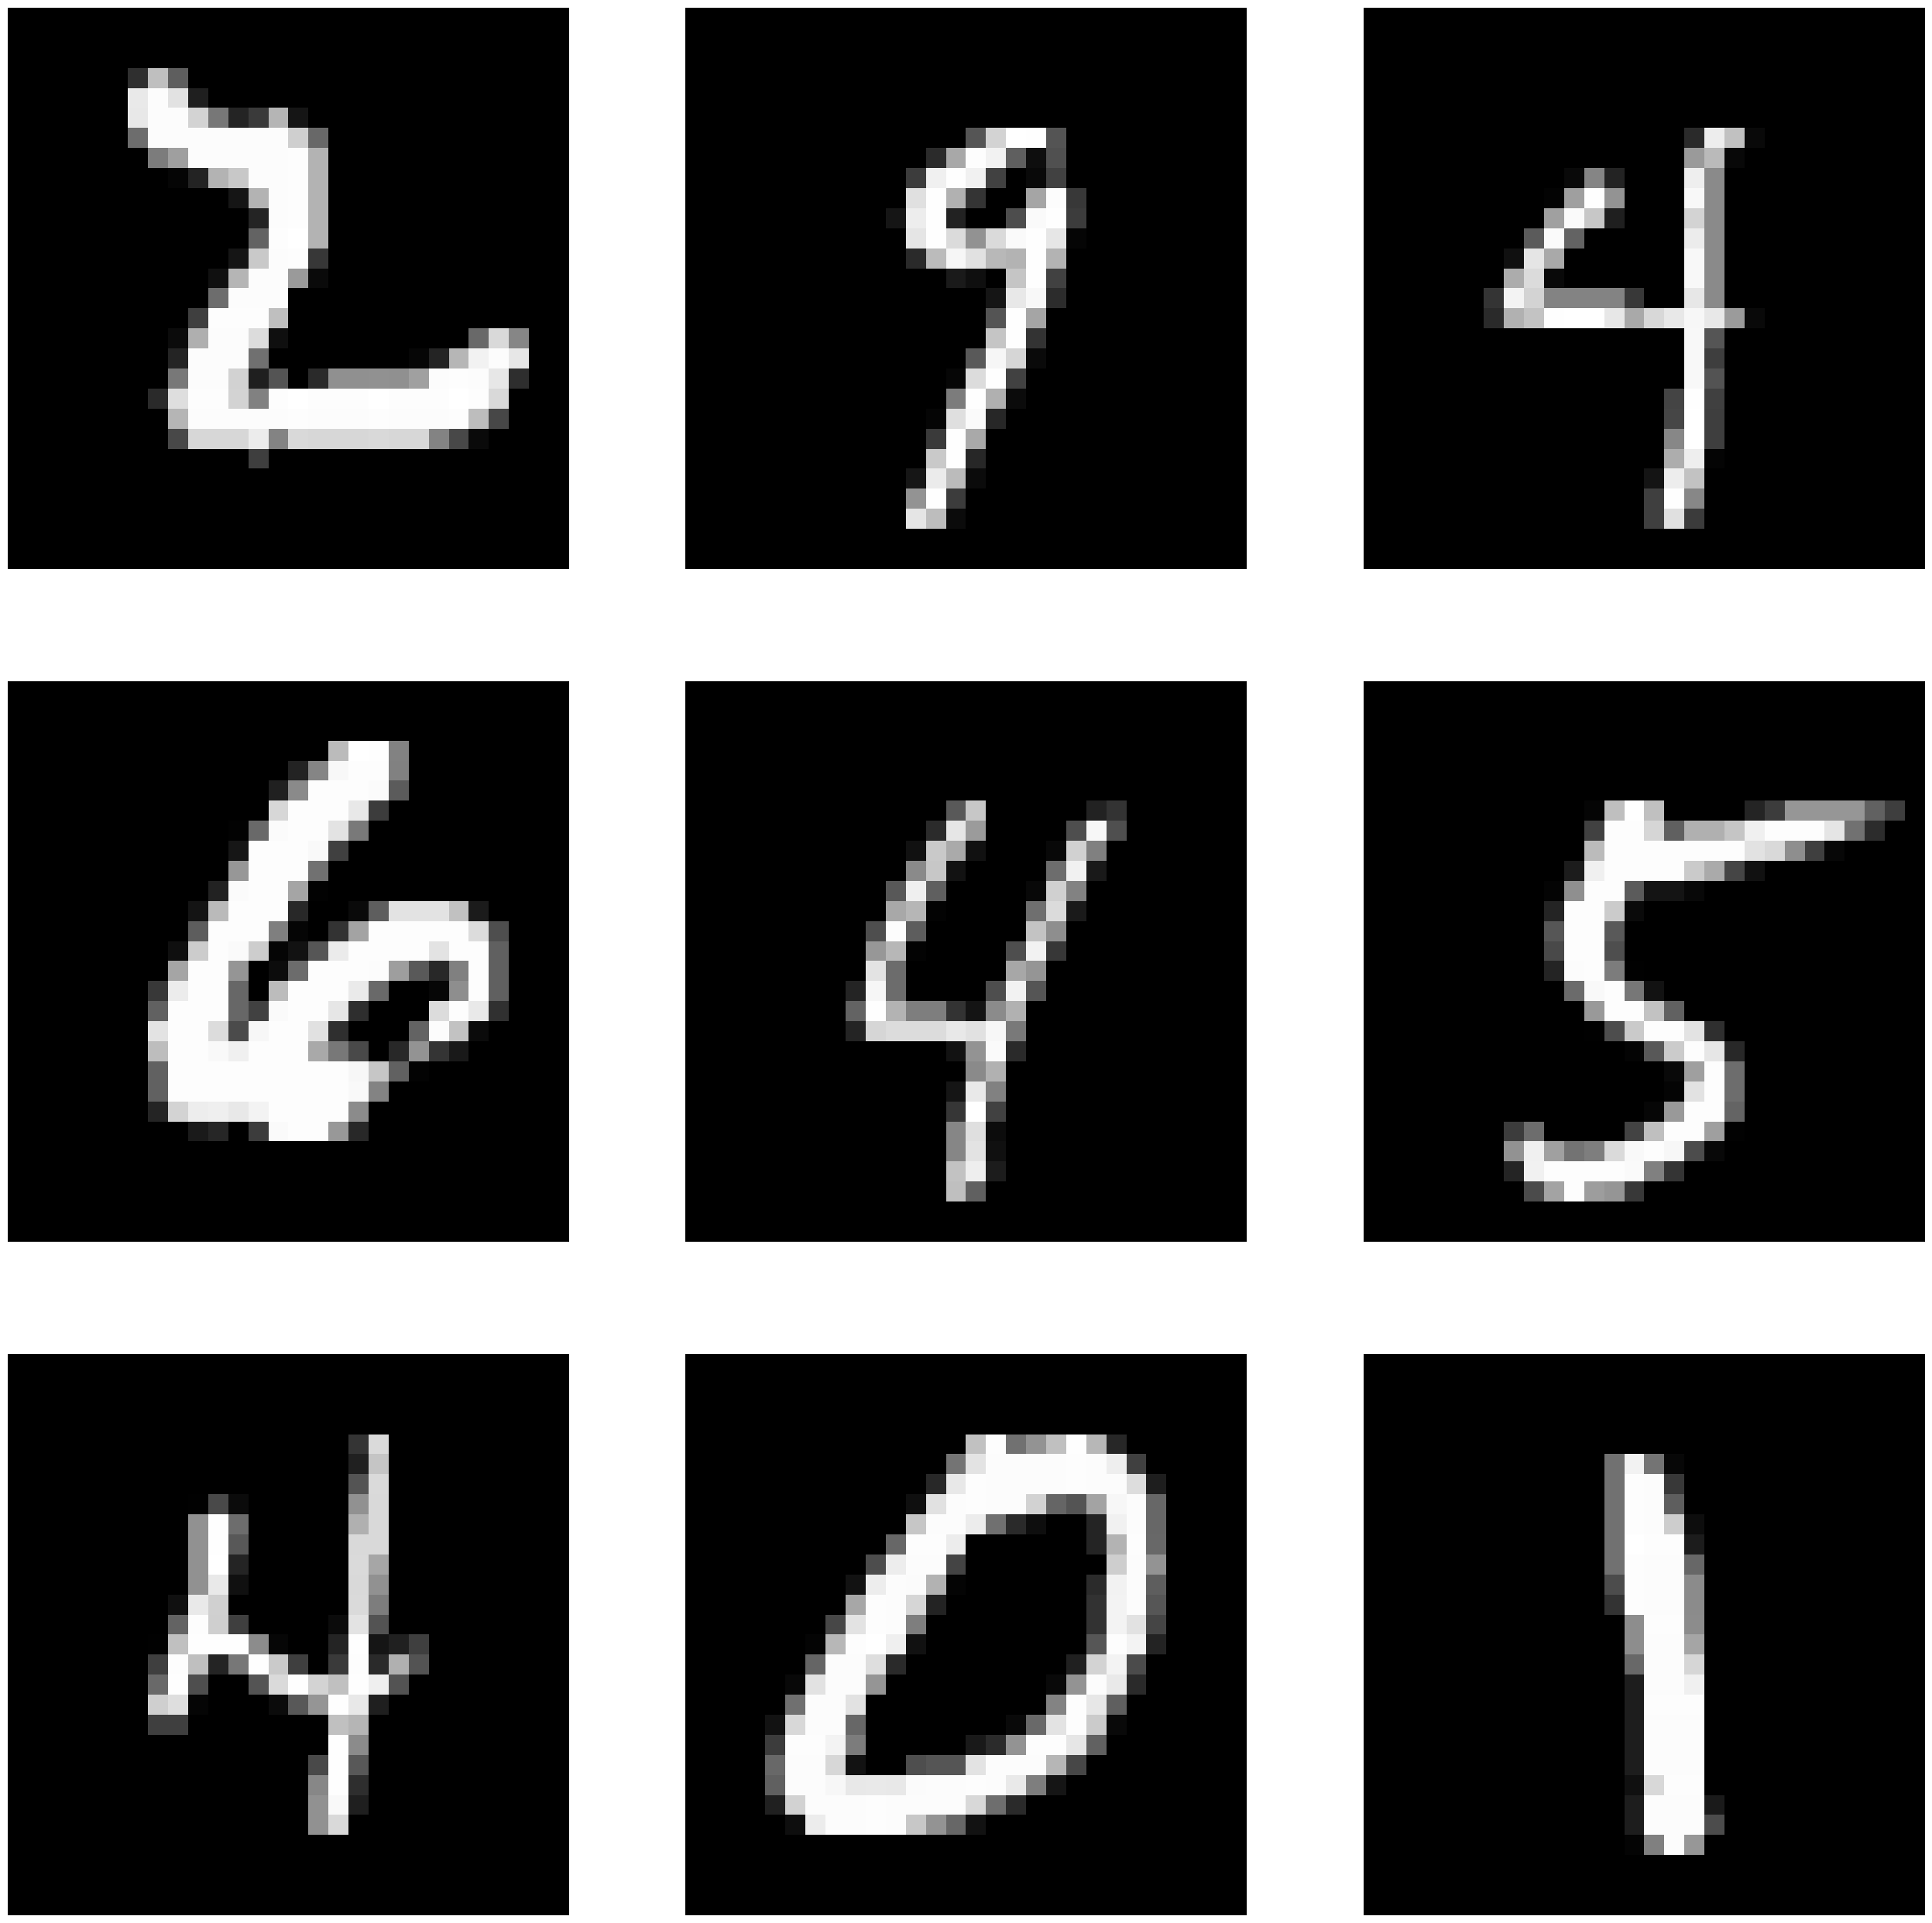

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.axis('off')

## O quão balanceado é o nosso treinamento?
Vamos encontrar quantas amostras estão contidas em cada classe e calular o peso das classes a partir disso. Isso é útil para dizer ao modelo que "preste mais atenção" em amostras sub-representadas, durante treinamento.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

unique, counts = np.unique(y_train, return_counts=True)
print ("Train ---> ", dict(zip(unique, counts)), "\n")

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)

train_class_weights = dict(enumerate(class_weights))
print (train_class_weights, "\n")

Train --->  {np.uint8(0): np.int64(4789), np.uint8(1): np.int64(5366), np.uint8(2): np.int64(4789), np.uint8(3): np.int64(4933), np.uint8(4): np.int64(4633), np.uint8(5): np.int64(4317), np.uint8(6): np.int64(4696), np.uint8(7): np.int64(4993), np.uint8(8): np.int64(4702), np.uint8(9): np.int64(4782)} 

{0: np.float64(1.0022969304656504), 1: np.float64(0.8945210585165859), 2: np.float64(1.0022969304656504), 3: np.float64(0.9730387188323535), 4: np.float64(1.0360457586876755), 5: np.float64(1.111883252258513), 6: np.float64(1.0221465076660987), 7: np.float64(0.9613458842379331), 8: np.float64(1.020842194810719), 9: np.float64(1.0037641154328734)} 



Para o conjunto de teste, usaremos isso para encontrar a acurácia balanceada:

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
print("Test ---> ", dict(zip(unique, counts)), "\n")

test_sample_per_class = counts

Test --->  {np.uint8(0): np.int64(980), np.uint8(1): np.int64(1135), np.uint8(2): np.int64(1032), np.uint8(3): np.int64(1010), np.uint8(4): np.int64(982), np.uint8(5): np.int64(892), np.uint8(6): np.int64(958), np.uint8(7): np.int64(1028), np.uint8(8): np.int64(974), np.uint8(9): np.int64(1009)} 



## Preprocessamento
Nossa rede irá receber um único vetor para cada exemplo no conjunto, então precisamos "reformatar" o conjunto para que cada imagem de $28\times 28$ se transforme em um único vetor de 784 dimensões. Iremos também escalar os valores para que fiquem no intervalo $[0, 1]$ em vez de $[0, 255]$.

In [ ]:
size = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], size)
X_val = X_val.reshape(X_val.shape[0], size)
X_test = X_test.reshape(X_test.shape[0], size)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (48000, 784)
Validation matrix shape (12000, 784)
Testing matrix shape (10000, 784)


Vamos modificar o vetor de rótulos para o formato *one-hot encoded*. Isto é:

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
...
9 -> [0, 0, 0, 0, 0, 0, 0, 0, 1]
```

In [ ]:
Y_train = to_categorical(y_train, nb_classes)
Y_val = to_categorical(y_val, nb_classes)
Y_test = to_categorical(y_test, nb_classes)
print("Training matrix shape", Y_train.shape)
print("Testing matrix shape", Y_test.shape)

Training matrix shape (48000, 10)
Testing matrix shape (10000, 10)


In [ ]:

print(Y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# Construíndo a rede
Aqui faremos uma simples rede com 4 camadas (input + duas camadas escondidas + saída), usando camadas densas (ou totalmente-conexas). Neste tipo de camada, cada unidade está conectado à cada unidade na camada anterioro. Se considerarmos a primeira camada escondida, cada unidade está conectada à cada pixel da imagem de entrada.
<img src="figure.png" />

Há duas formas de se instanciar redes em Keras. Uma delas é instanciando um modelo `Sequential` com uma lista de camadas. A primeira camada da rede precisa receber o parâmetro `input_shape` para que o modelo saiba calcular o número de parâmetros.

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Porém, a forma mais comum é utilizando a API funcional do Keras:

In [ ]:
ipt = Input(shape = (784,))
x = Dense(512, activation='relu')(ipt)
y = Dense(512, activation='relu')(x)
out = Dense(10, activation='softmax')(y)

model = Model(inputs=ipt, outputs=out)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

## Compile o modelo
Keras é construido sobre o Tensorflow, Theano ou CNTK, bibliotecas de computação que permitem a utilização de diferentes dispositivos (ex.: CPU, GPU, nós em uma rede) de forma transparente e eficiente.

Quando compilando um modelo, Keras requer que você especifique uma **função de perda**, seu **otimizador** e algumas **métricas**. A função de perda que usaremos aqui é chamada de *categorical crossentropy*, e é a função mais adequada para comparar duas distribuições de probabilidade.

Aqui nossas predições são distribuições de probabilidade de 10 diferentes dígitos (ex: "estamos 80% confiante que esta imagem é um 3, 10% confiante que é um 8, 5% um 2 etc"), e o alvo é a probabilidade de 100% para a categoria correta e 0% para todas as demais. A *cross-entropy* é a medida do quão diferente sua distribuição de predição é da distribuição alvo. [Veja mais na Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

O [otimizador](https://keras.io/optimizers) ajuda a determinar o quão rápido um modelo aprende, quão resiliente ele será à "estagnação" ou "explosão" durante o treinamento. Neste exercício, utilizaremos uma variação do gradiente descendente chamado **Stocastic Gradient Descent (SGD)**. Em vez de considerar todo o conjunto de treinamento a cada iteração, o SGD somente utiliza uma pequena amostra aleatória dos dados disponíveis a cada vez.

Além disso, podemos definir um número de métricas (como acurácia, MSE, MAE) para observar durante o treinamento. **Entretanto, Keras não se utiliza da acurácia balanceada!**

In [ ]:
sgd = optimizers.SGD(learning_rate = 0.01) #lr = learning rate
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

## Treine seu modelo!
Essa é a parte divertida: você pode alimentar seu modelo com os dados de treino carregados anteriormente e ele aprenderá a classificar digitos!

Primeiro, vamos entender os argumentos:
- **X_train & Y_train:** as amostras e rótulos de treino
- **batch_size:** em vez de otimizar os parâmetros da rede sobre todo o conjunto de treino, nós usualmente atualizamos a cada *batch* (pequenas amostras do conjunto de treino). Neste caso, vamos atualizar nossos pesos (*backpropagation*) a cada 128 imagens
- **epochs:** uma época na qual todos os *batches* contidos no conjunto de treino foram processados. Diremos que o conjunto de dados será processado 8 vezes
- **verbose:** mostrar as métricas ao fim de cada época
- **class_weight:** os pesos de cada classe, considerando que elas não são balanceadas. Isso irá ponderar a perda baseando-se em quão frequente cada classe é
- **validation_data:** ao final de cada época, nosso modelo é utilizado para predizer este conjunto e exibir o valor de perda e métricas especificadas.

In [ ]:
model.fit(X_train, Y_train,
          batch_size = 128, epochs = 8, verbose = 1,
          class_weight = train_class_weights,
          validation_data=(X_val, Y_val))

Epoch 1/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5509 - loss: 1.7357 - val_accuracy: 0.8529 - val_loss: 0.6489
Epoch 2/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8679 - loss: 0.5701 - val_accuracy: 0.8859 - val_loss: 0.4344
Epoch 3/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8938 - loss: 0.4089 - val_accuracy: 0.8986 - val_loss: 0.3672
Epoch 4/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9025 - loss: 0.3550 - val_accuracy: 0.9082 - val_loss: 0.3357
Epoch 5/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9102 - loss: 0.3217 - val_accuracy: 0.9112 - val_loss: 0.3115
Epoch 6/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9179 - loss: 0.2930 - val_accuracy: 0.9151 - val_loss: 0.2964
Epoch 7/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9242 - loss: 0.2758 - val_accuracy: 0.9193 - val_loss: 0.2823
Epoch 8/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9240 - loss: 0.2709 - val_accuracy: 0.9233 - 

## Finalmente, avaliamos a performance sobre um conjunto de teste

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT BALANCED):', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9176 - loss: 0.2894
Test loss: 0.24970877170562744
Test accuracy (NOT BALANCED): 0.9289000034332275


## Acurácia Balanceada

In [ ]:
# O método predict retorna o vetor softmax com as probabilidades de cada classe.
probs = model.predict(X_test)
print("Probs = ", probs[0,:])
predicted_classes = np.argmax(probs, axis=-1)
print("Class = ", predicted_classes[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Probs =  [1.9512606e-04 2.2988045e-06 3.1835856e-04 1.6704531e-03 5.8194682e-06
 1.1780728e-04 1.8709130e-07 9.9663216e-01 5.8298039e-05 9.9936407e-04]
Class =  7


In [ ]:
# Calcular a classe correta, utilizando o vetor `one-hot encoded`
# que contém as classes referentes às amostras de teste.
Y_test_classes = np.argmax(Y_test, axis=-1)

accPerClass = []
for classIdx in range(nb_classes):
    idx = (Y_test_classes == classIdx)

    correctPred = np.sum(predicted_classes[idx] == Y_test_classes[idx])
    accPerClass.append( correctPred / float(test_sample_per_class[classIdx]))

print (dict(zip(range(nb_classes),accPerClass)), "\n")
print ("Balanced Acc --> ", np.mean(accPerClass))

{0: np.float64(0.9846938775510204), 1: np.float64(0.9806167400881057), 2: np.float64(0.9040697674418605), 3: np.float64(0.9118811881188119), 4: np.float64(0.9266802443991853), 5: np.float64(0.8946188340807175), 6: np.float64(0.9405010438413361), 7: np.float64(0.919260700389105), 8: np.float64(0.9045174537987679), 9: np.float64(0.9137760158572844)} 

Balanced Acc -->  0.9280615865566194


### Inspecionando a saída

É sempre uma boa ideia inspecionar a saída e verificar que tudo parece adequado. Aqui, iremos olhar para alguns exemplos que o modelo acerta e alguns que ele erra.

In [ ]:
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

# Determina os índices das amostras que foram preditas corretamente/incorretamente
correct_indices, = np.where(predicted_classes == y_test)
incorrect_indices, = np.where(predicted_classes != y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


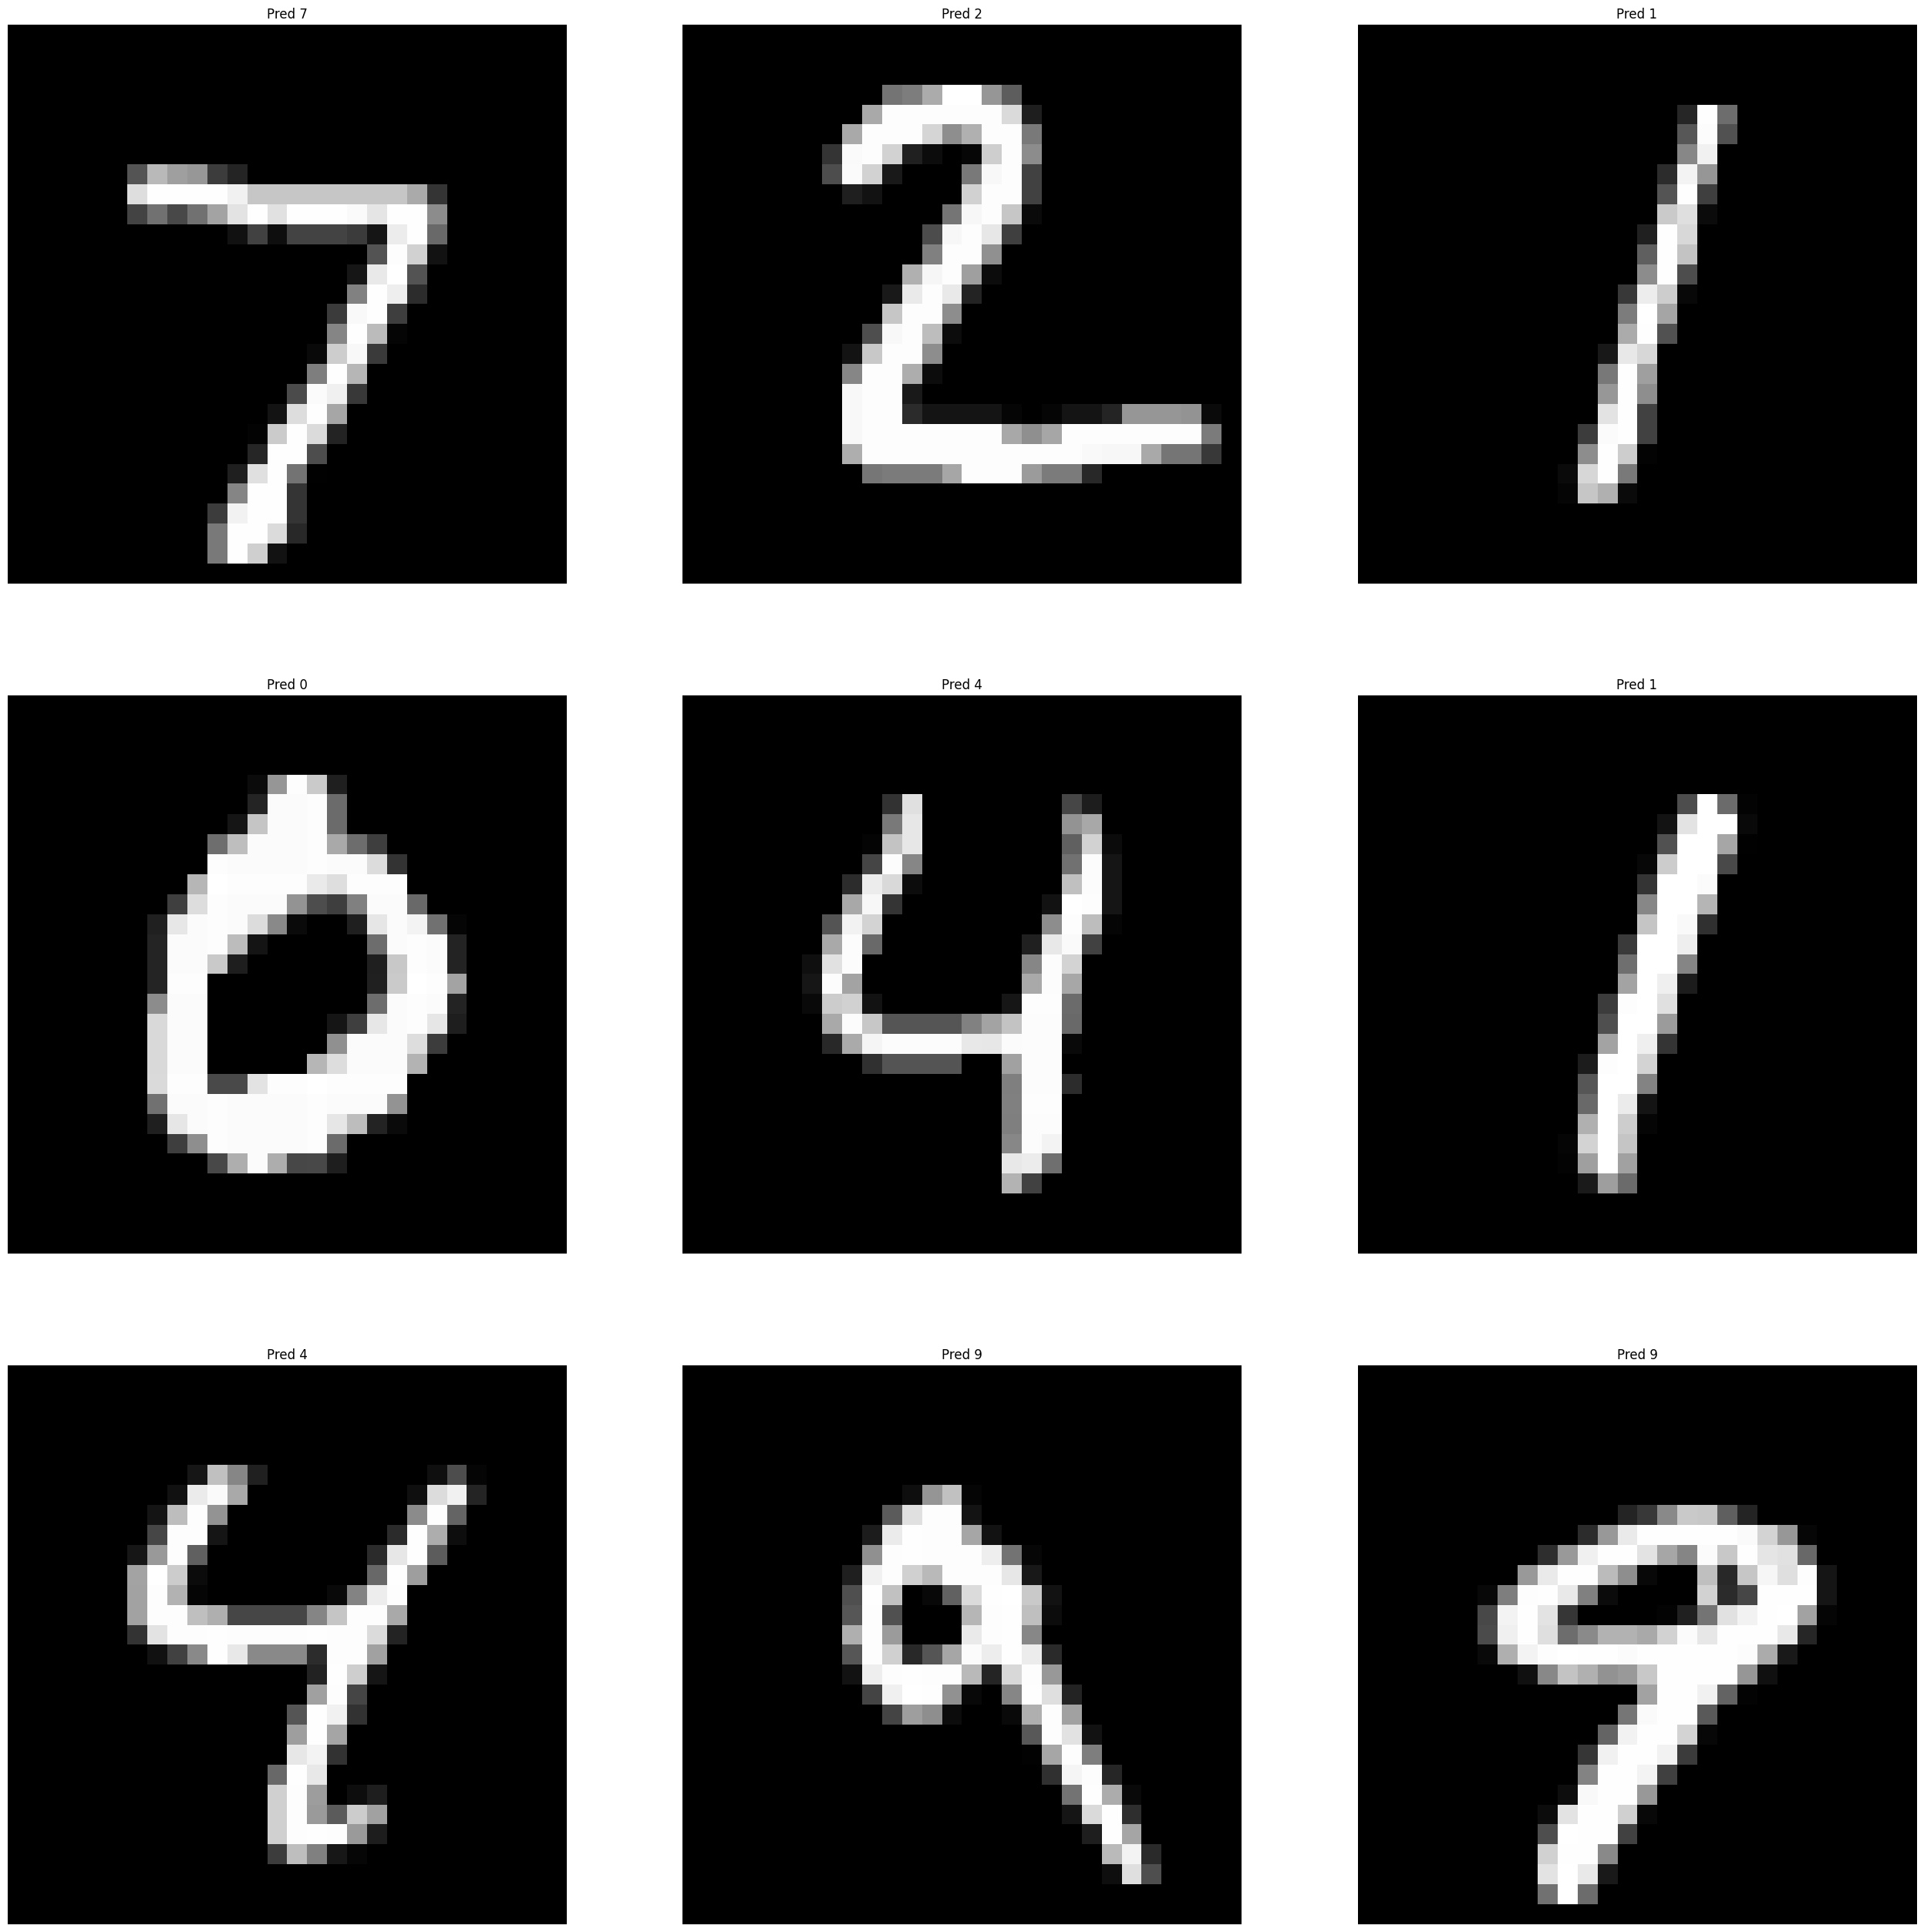

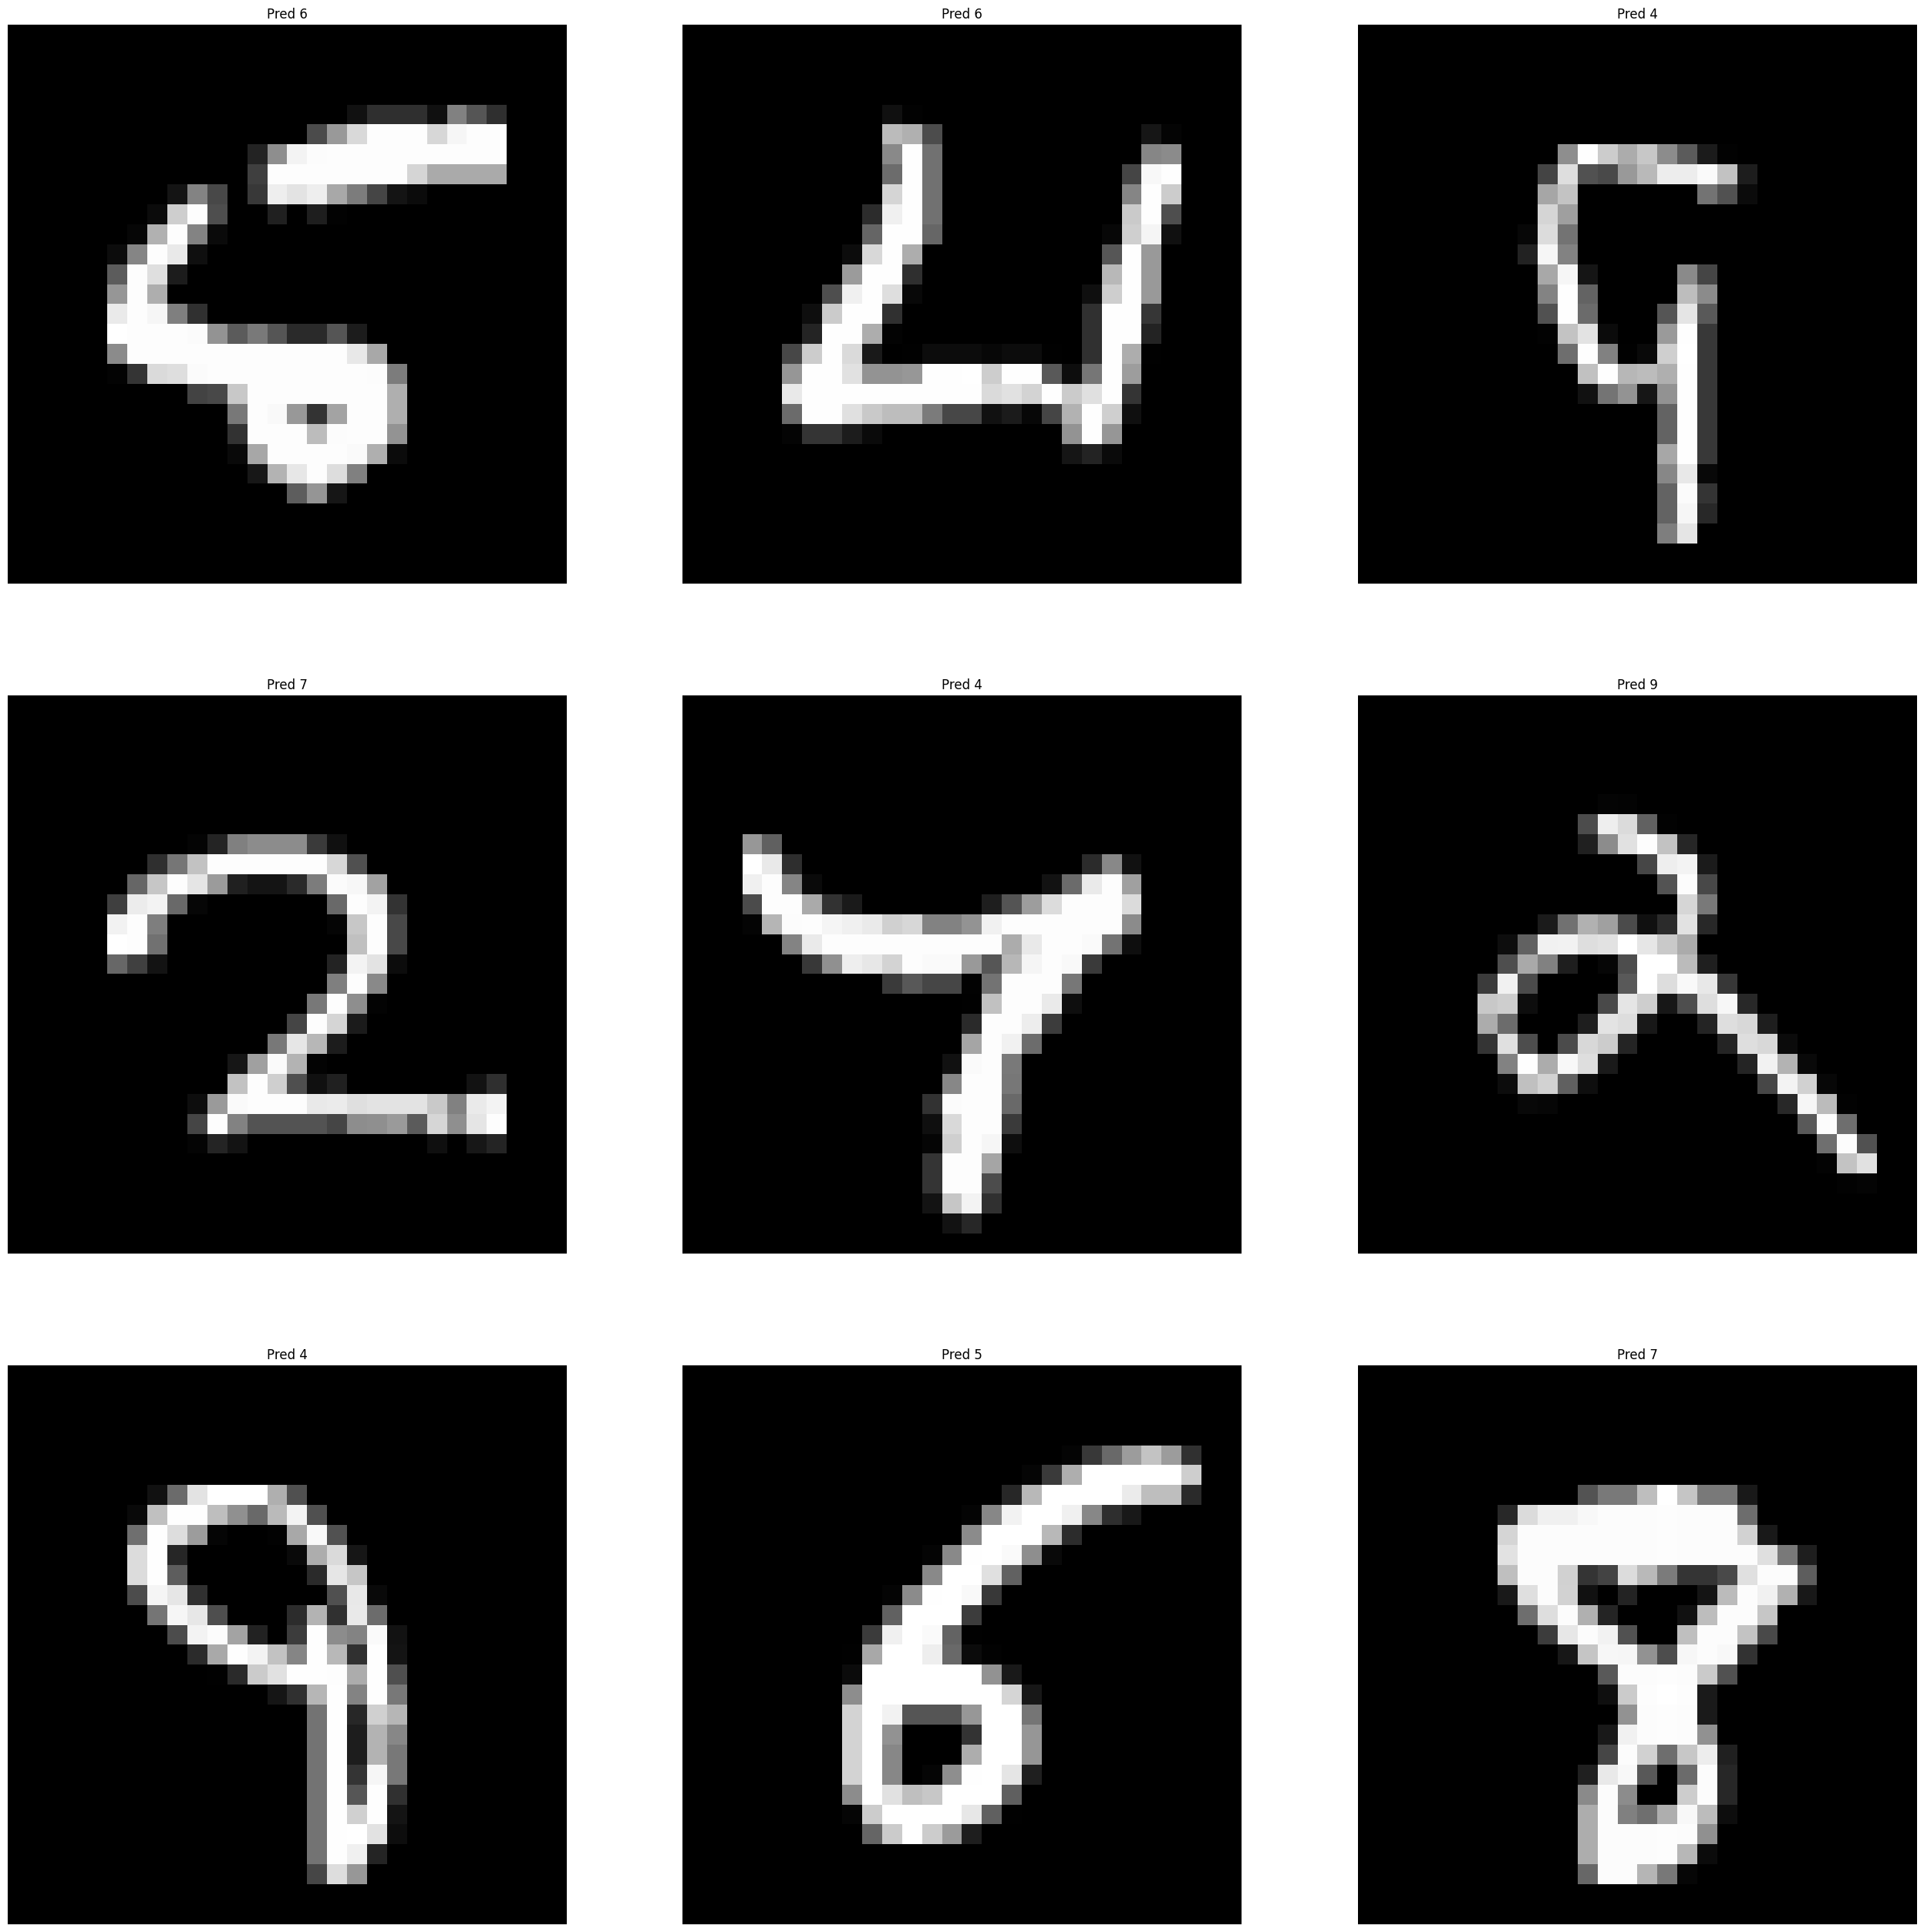

In [ ]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Pred {}".format(predicted_classes[correct]))
    plt.axis('off')

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Pred {}".format(predicted_classes[incorrect]))
    plt.axis('off')

# Referencias

Existem vários outros ótimos exemplos na página do Keras http://keras.io e em seu código-fonte https://github.com/keras-team/keras. Além desses, este notebook foi adaptado [daqui](https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb).